In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/Seg3D/KiTS2019/kits19'

/content/drive/MyDrive/Seg3D/KiTS2019/kits19


In [3]:
# !pip install -r requirements.txt

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as load_batch

from segment.data.prepare_data import get_dataset
from segment.data.data_readers.data_reader import DatasetReader
from segment.data.data_loaders.processor import DataProcessor

In [5]:
train_ds, valid_ds = get_dataset(
    data_path="/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/train_val_data.json", 
    out_path="/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/data",
    config_path="configs/preprocess_pipeline.yaml",
    fold=1
) 


INFO:segment.utils.file_utils:The number of data at 210
INFO:segment.utils.file_utils:The number of train dataset is 189
INFO:segment.utils.file_utils:Saved train dataset at /content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/data/train_dataset.pt


config file:
 {'input_size': [80, 80, 160], 'expand_slice_z': 30, 'expand_slice_y': 15, 'expand_slice_x': 15, 'crop_type': 'random', 'use_bground': True, 'z_range': [35, 80], 'y_range': [100, 165], 'x_range': [55, 200]}


INFO:segment.utils.file_utils:The number of valid dataset is 21
INFO:segment.utils.file_utils:Saved valid dataset at /content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/data/valid_dataset.pt


In [6]:
# [data for data in train_ds]

In [7]:
data = torch.load("/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/data/train_dataset.pt")

In [8]:
# use dataloader to avoid random access in dataset
data = next(iter(load_batch(data, batch_size=32)))
volume, seg = data

In [9]:
example = seg[1, 1, ...]
print(seg.shape)
print(example.shape)
np.where(example.sum(dim=(1,2)) > 0)[0]

torch.Size([32, 3, 80, 80, 160])
torch.Size([80, 80, 160])


array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [15]:
print(np.unique(seg[0, 0]))
print(np.unique(seg[0, 1]))
print(np.unique(seg[0, 2]))

[0 1]
[0 1]
[0 1]


In [16]:
def check_nonzero_slice(item):
    organ_arr, tumor_arr = item[1, ...], item[2, ...]
    organ_func = DatasetReader.locate_nonzero_slice(organ_arr, t=0, return_rate=False)
    tumor_func = DatasetReader.locate_nonzero_slice(tumor_arr, t=0, return_rate=False)
    return organ_func, tumor_func

result = list(map(check_nonzero_slice, seg))


idc: 1
{'nonzero_z_min': 24, 'nonzero_z_max': 67, 'nonzero_y_min': 0, 'nonzero_y_max': 62, 'nonzero_x_min': 6, 'nonzero_x_max': 138}
{'nonzero_z_min': 50, 'nonzero_z_max': 59, 'nonzero_y_min': 9, 'nonzero_y_max': 26, 'nonzero_x_min': 125, 'nonzero_x_max': 144}
torch.Size([80, 80, 160])
torch.Size([80, 80, 160])
random_pos: 52


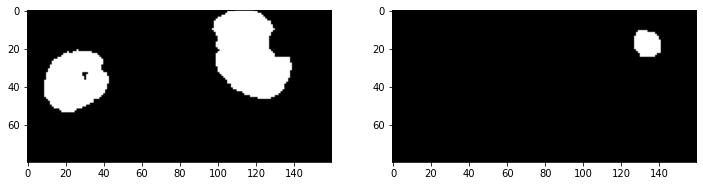

In [35]:
idc = np.random.choice(len(seg))
print("idc:", idc)
print(result[idc][0])
print(result[idc][1])

bground_arr, random_organ_arr, random_tumor_arr = seg[idc][0], seg[idc][1], seg[idc][2]

print(random_organ_arr.shape)
print(random_tumor_arr.shape)

random_pos = np.random.choice(random_tumor_arr.shape[0])
print("random_pos:", random_pos)

_, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(random_organ_arr[random_pos], cmap=plt.cm.gray)
axes[1].imshow(random_tumor_arr[random_pos], cmap=plt.cm.gray)
plt.show()


In [36]:
print(random_organ_arr.shape, random_tumor_arr.shape)
print(np.unique(bground_arr), np.unique(random_organ_arr), np.unique(random_tumor_arr))

torch.Size([80, 80, 160]) torch.Size([80, 80, 160])
[0 1] [0 1] [0 1]


In [47]:
msk = torch.stack([bground_arr, random_organ_arr, random_tumor_arr])
msk.shape

torch.Size([3, 80, 80, 160])

In [48]:
preds_max = np.argmax(msk, axis=0)
preds_max.shape

torch.Size([80, 80, 160])

In [49]:
print(np.unique(preds_max))

[0 1 2]


In [51]:
import copy

preds_bground = copy.deepcopy(preds_max)
preds_bground[preds_max != 0] = 0
preds_bground[preds_max == 0] = 1

preds_organ = copy.deepcopy(preds_max)
preds_organ[preds_max != 1] = 0
preds_organ[preds_max == 1] = 1

preds_tumor = copy.deepcopy(preds_max)
preds_tumor[preds_max != 2] = 0
preds_tumor[preds_max == 2] = 1

print(preds_tumor.shape)
print(preds_organ.shape)

final_preds = np.stack([preds_organ, preds_tumor])
print(final_preds.shape)
print(np.unique(final_preds))

torch.Size([80, 80, 160])
torch.Size([80, 80, 160])
(2, 80, 80, 160)
[0 1]


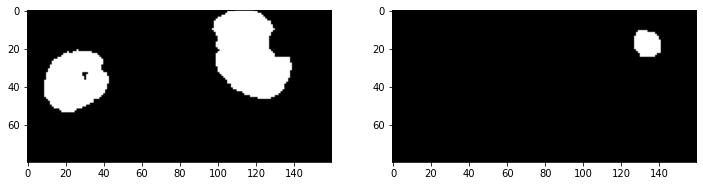

In [52]:
_, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(final_preds[0, 52], cmap=plt.cm.gray)
axes[1].imshow(final_preds[1, 52], cmap=plt.cm.gray)
plt.show()